In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy import stats

## Loading Dataset

In [13]:
dataframe = pd.read_csv('database.csv', na_values=[''])

## Ordering Columns

In [14]:
dataframe.columns.tolist()

['Unnamed: 0',
 'row_close',
 'levelCounter',
 'trial_set',
 'row_start',
 'time_secs',
 'ptcp',
 'feedbackType',
 'correctCounter',
 'Change Flag']

In [15]:
new_order = ['ptcp',
             'trial_set',
             'levelCounter',
             'row_start',
             'row_close',
             'time_secs',
             'feedbackType',
             'correctCounter',
             'Change Flag']

In [16]:
work_df = dataframe[new_order]

## Data Validation

First we need to watch if after the tranformations of the raw-data all conditions look as expected

I am going to start by looking at a participant, set level. We expect 22 participants and 36 trials per set. 

In [17]:
# Group the DataFrame by 'ptcp' and 'trial_set', then count unique values in 'levelCounter'
levels_per_set_per_participant = work_df.groupby(['ptcp', 'trial_set'])['levelCounter'].count()

# Display the result
print("\nNumber of levels per set per participant:")
print(levels_per_set_per_participant)


Number of levels per set per participant:
ptcp    trial_set
tsvr06  1            36
        2            36
        3            36
tsvr07  1            36
        2            36
                     ..
tsvr26  2            36
        3            35
tsvr27  1            36
        2            36
        3            35
Name: levelCounter, Length: 66, dtype: int64


Due to a failure in the excecution of the program the last level (35) is missing for most participants in set 3. I think we need to remove it for all participants in all sets since we don' want to umbalanced the results. 

In [18]:
# Group the DataFrame by 'ptcp' and 'trial_set', then count unique values in 'levelCounter'
#feedbacktype_per_set_per_participant = work_df.groupby(['ptcp', 'trial_set'])['feedbackType'].count()

# Convert the result to a DataFrame
#feedbacktype_per_set_per_participant_df = feedbacktype_per_set_per_participant.reset_index()

# Display result
#print(feedbacktype_per_set_per_participant_df)

# Adding flag for missing values 
#feedbacktype_per_set_per_participant_df['missing_flag'] = np.where(36 - feedbacktype_per_set_per_participant_check_per_level['feedbackType'] > 0, 1, 0)

# removing 
work_df2 =  work_df[work_df['levelCounter']<35]

In [19]:
# Group the DataFrame by 'ptcp' and 'trial_set', then count unique values in 'levelCounter'
check_per_level = work_df2.groupby(['levelCounter','feedbackType']).count()
check_per_level = check_per_level.reset_index()
check_per_level['deviation']= 22-check_per_level['ptcp']
print(check_per_level)



     levelCounter feedbackType  ptcp  trial_set  row_start  row_close  \
0             0.0    congruent    21         21         21         21   
1             0.0  incongruent    22         22         22         22   
2             0.0         none    23         23         23         23   
3             1.0    congruent    23         23         23         23   
4             1.0  incongruent    23         23         23         23   
..            ...          ...   ...        ...        ...        ...   
100          33.0  incongruent    21         21         21         21   
101          33.0         none    25         25         25         25   
102          34.0    congruent    26         26         26         26   
103          34.0  incongruent    19         19         19         19   
104          34.0         none    21         21         21         21   

     time_secs  correctCounter  Change Flag  deviation  
0           21              21           21          1  
1        

Not all the levels have the same amount of stimuli there is a deviation. We will t-test next if this deviation is different from 

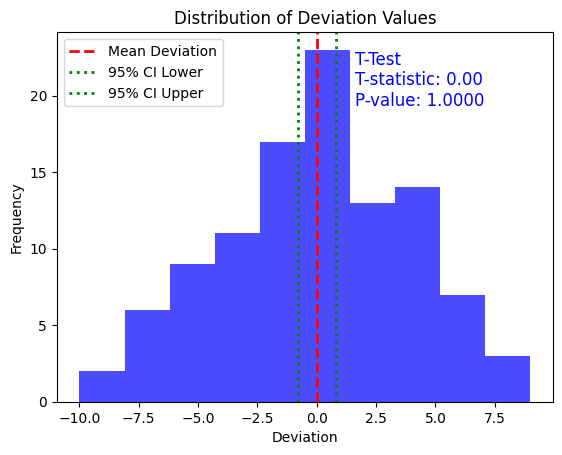

In [34]:

# Assuming your DataFrame is named check_per_level
deviation_values = check_per_level['deviation']

# Create the histogram
plt.hist(deviation_values, bins=10, color='blue', alpha=0.7)
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Deviation Values')

# Calculate the mean and standard error of the mean (SEM)
mean_deviation = np.mean(deviation_values)
sem_deviation = np.std(deviation_values) / np.sqrt(len(deviation_values))

# Calculate the 95% confidence interval
ci_lower = mean_deviation - 1.96 * sem_deviation
ci_upper = mean_deviation + 1.96 * sem_deviation

# Perform a t-test (assuming a population mean of 0)
t_stat, p_value = stats.ttest_1samp(deviation_values, 0)

# Add the confidence interval and t-test result to the plot
plt.axvline(mean_deviation, color='red', linestyle='dashed', linewidth=2, label='Mean Deviation')
plt.axvline(ci_lower, color='green', linestyle='dotted', linewidth=2, label='95% CI Lower')
plt.axvline(ci_upper, color='green', linestyle='dotted', linewidth=2, label='95% CI Upper')

# Add t-test result to the plot
plt.annotate(f'T-Test\nT-statistic: {t_stat:.2f}\nP-value: {p_value:.4f}', xy=(0.6, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

plt.legend(loc='upper left')
plt.show()


This shows that the median deviation of ptcp per category is 0. Which supports the argument that after removing level 36 of all the sample feedbacktype remains independent variable. 

Now taking a view on the participants. We expect 35 trails per condition per participant 

In [32]:
# Group the DataFrame by 'ptcp' and 'trial_set', then count unique values in 'levelCounter'
check_per_ptcp = work_df2.groupby(['ptcp','feedbackType']).count()
check_per_ptcp = check_per_ptcp.reset_index()
check_per_ptcp['deviation']= 35-check_per_ptcp['trial_set']
print(check_per_ptcp)

      ptcp feedbackType  trial_set  levelCounter  row_start  row_close  \
0   tsvr06    congruent         35            35         35         35   
1   tsvr06  incongruent         34            34         34         34   
2   tsvr06         none         36            36         36         36   
3   tsvr07    congruent         35            35         35         35   
4   tsvr07  incongruent         33            33         33         33   
..     ...          ...        ...           ...        ...        ...   
61  tsvr26  incongruent         35            35         35         35   
62  tsvr26         none         35            35         35         35   
63  tsvr27    congruent         35            35         35         35   
64  tsvr27  incongruent         34            34         34         34   
65  tsvr27         none         36            36         36         36   

    time_secs  correctCounter  Change Flag  deviation  
0          35              33           33          0  

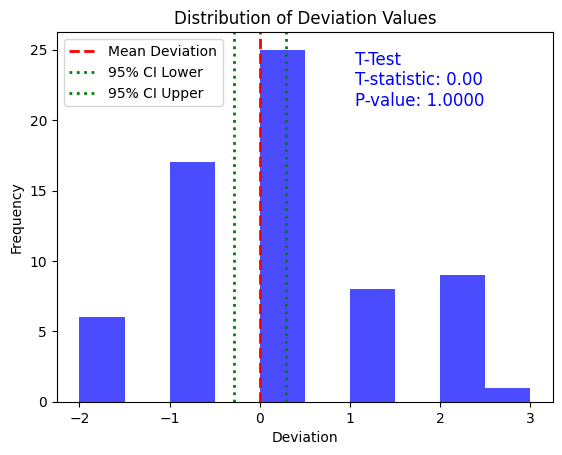

In [35]:
# Assuming your DataFrame is named check_per_level
deviation_values = check_per_ptcp['deviation']

# Create the histogram
plt.hist(deviation_values, bins=10, color='blue', alpha=0.7)
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Deviation Values')

# Calculate the mean and standard error of the mean (SEM)
mean_deviation = np.mean(deviation_values)
sem_deviation = np.std(deviation_values) / np.sqrt(len(deviation_values))

# Calculate the 95% confidence interval
ci_lower = mean_deviation - 1.96 * sem_deviation
ci_upper = mean_deviation + 1.96 * sem_deviation

# Perform a t-test (assuming a population mean of 0)
t_stat, p_value = stats.ttest_1samp(deviation_values, 0)

# Add the confidence interval and t-test result to the plot
plt.axvline(mean_deviation, color='red', linestyle='dashed', linewidth=2, label='Mean Deviation')
plt.axvline(ci_lower, color='green', linestyle='dotted', linewidth=2, label='95% CI Lower')
plt.axvline(ci_upper, color='green', linestyle='dotted', linewidth=2, label='95% CI Upper')

# Add t-test result to the plot
plt.annotate(f'T-Test\nT-statistic: {t_stat:.2f}\nP-value: {p_value:.4f}', xy=(0.6, 0.8), xycoords='axes fraction', fontsize=12, color='blue')

plt.legend(loc='upper left')
plt.show()